## Adversarial Generation

We uses 'foolbox' to help us generate adversarial images. This save us the trouble of implementing each attack ourselves. Additionally, with 'foolbox', during our preliminary research we are able to try out different attacks before choosing the attacks we will use in our project. This would not be possible if we were to implement each attack from scratch ourselves, as it is much more tedious and thus prevents us from trying out a multitude of different attacks.

(Note that we uses TensorFlow backend. If you are using Theano instead, some tweaks need to be made to the image reshaping.)

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

import foolbox         # foolbox is a package for easy generation of adversarial attacks.
from tqdm import tqdm  # tqdm is a function that automatically generate a loading bar for loops.

from keras.datasets import cifar10, mnist, fashion_mnist

Using TensorFlow backend.


In [24]:
def gen_adv_images(fmodel, images, labels, cont=0, numImages= 10000, epsilon=0.3):
    """Generate adversarial images and save in a .npy file.
    
    The 'attack' object is changed based on which attack we want.
    Attacks used:
        foolbox.attacks.FGSM(fmodel)
        foolbox.attacks.DeepFoolAttack(fmodel)
        foolbox.attacks.SinglePixelAttack(fmodel)
        foolbox.attacks.SaliencyMapAttack(fmodel)
        
    More attacks: https://foolbox.readthedocs.io/en/latest/modules/attacks.html
    
    cont       :    cont means continue and is used to set the first image index.
                    This allows you to resume the generation from a specific index.
    
    numImages  :    The number of images to generate, starting from cont index.

    epsilon    :    epsilon is only used for FGSM attack to set the magnitude of perturbation.
                    Not providing an epsilon will cause the attack algorithm to search for
                    a minimum epsilon value, extending the generation runtime but providing
                    a better adversarial attack.
    """

    attack = foolbox.attacks.FGSM(fmodel)
    adversarial_images = np.zeros(np.shape(images))

    for i in tqdm(range(numImages)):
        image = images[i + cont]
        label = labels[i + cont]      # If images are greyscale
        #label = labels[i + cont][0]  # If images are RGB
        
        adversarial = attack(image, label, epsilons=[epsilon])
        adversarial_images[i] = adversarial

    np.save('adversarial_img.npy', adversarial_images)


In [2]:
# Load foolbox model as keras model
keras.backend.set_learning_phase(0)
kmodel = keras.models.load_model('MNIST Data/mnist.h5')
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 1))

# For CIFAR10
#mean = np.array([0.4914, 0.4822, 0.4465]).reshape((1, 1, 3))
#std = np.array([0.2023, 0.1994, 0.2010]).reshape((1, 1, 3))
#fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 1), preprocessing=(mean, std))

# Load image datasets
_, (images, labels) = mnist.load_data()

images = images.reshape(10000, 28, 28, 1)  # For MNIST and Fashion-MNIST
images = images.astype('float32')
images = images / 255

In [ ]:
# Start generating adversarial iamges

# Generation takes a long time depending on the attack, datasets and model,
# recommended to generate in batches using cont and numImages.
# Batches can be concatenated later using np.concatenate.

gen_adv_images(fmodel, images, labels, cont=0, numImages=10000)

# Note that the program outputs NaN images if an adversarial perturbation is not found.
# This happens frequently for SinglePixelAttack for CIFAR10 due to the robustness of model.
# One can also increase the max iterations to generate the adversarial, but this increases computing time.
# Look at the docs for more info: https://foolbox.readthedocs.io/en/latest/modules/attacks.html

In [35]:
# Load adversarial images
adversarial_images = np.load('MNIST Data/mnist_fgsm_adv.npy')

In [ ]:
# Evaluate the accuracy of the model in classifying the adversarial images.
scores = kmodel.evaluate(adversarial_images, np_utils.to_categorical(labels), batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1] * 100, scores[0]))

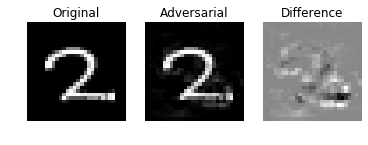

In [34]:
# Visualising the attacks
# For CIFAR10, reshape into (32, 32, 3), and remove cmap='gray'
imgIndex = 77
imgPlot = images[imgIndex].reshape(28, 28)
adversarialPlot = adversarial_images[imgIndex].reshape(28, 28)

plt.figure()
plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(imgPlot, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarialPlot, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarialPlot - imgPlot
plt.imshow(difference / abs(difference).max(), cmap='gray')
plt.axis('off')
plt.show()